In [1]:
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1
%aimport utils_data
%aimport utils_model
%aimport utils_attack

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Datasets and dataloaders preparation 

In [3]:
# (train_set, test_set), (train_loader, test_loader) = utils_data.get_train_test_dataloaders(
#     dataset_type='cifar10', 
#     root_data_folder='./data', 
#     batch_size=64
# )

Because of the problem with the cell above for CIFAR10 use the cell below

In [4]:
import os
import random
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

'''source https://github.com/kuangliu/pytorch-cifar/blob/master/main.py'''
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

data_folder = '/home/Skoltech_MSc/ML/HW2_v1.0/data'

train_set = torchvision.datasets.CIFAR10(
    root=data_folder, train=True, 
    download=False, transform=train_transform
)
test_set = torchvision.datasets.CIFAR10(
    root=data_folder, train=False,
    download=False, transform=test_transform
)

batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size,
    shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size,
    shuffle=False, num_workers=2
)

# Model

## Loading and fine-tuning ResNet50 pretrained on ImageNet 
**(you can skip this part if you already have a model pretrained on CIFAR10/100)**

In [5]:
model = torchvision.models.resnet50(pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
utils_data.set_random_seeds(seed_value=123, device=device)

'''source https://github.com/kuangliu/pytorch-cifar/blob/master/main.py'''
optimizer = optim.SGD(model.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

criterion = nn.CrossEntropyLoss()

In [7]:
model = utils_model.train(train_loader, test_loader, model, criterion, optimizer, scheduler, n_epochs=10, device=device)

 10%|█         | 1/10 [01:04<09:40, 64.52s/it]

[Epoch 1] train loss: 1.111; train acc: 0.61; test loss: 0.696; test acc: 0.76


 20%|██        | 2/10 [02:08<08:35, 64.49s/it]

[Epoch 2] train loss: 0.701; train acc: 0.76; test loss: 0.600; test acc: 0.79


 30%|███       | 3/10 [03:13<07:30, 64.38s/it]

[Epoch 3] train loss: 0.579; train acc: 0.80; test loss: 0.511; test acc: 0.82


 40%|████      | 4/10 [04:17<06:27, 64.50s/it]

[Epoch 4] train loss: 0.515; train acc: 0.82; test loss: 0.480; test acc: 0.83


 50%|█████     | 5/10 [05:22<05:22, 64.53s/it]

[Epoch 5] train loss: 0.463; train acc: 0.84; test loss: 0.475; test acc: 0.84


 60%|██████    | 6/10 [06:26<04:17, 64.47s/it]

[Epoch 6] train loss: 0.425; train acc: 0.85; test loss: 0.447; test acc: 0.85


 70%|███████   | 7/10 [07:31<03:13, 64.40s/it]

[Epoch 7] train loss: 0.386; train acc: 0.87; test loss: 0.428; test acc: 0.86


 80%|████████  | 8/10 [08:36<02:09, 64.57s/it]

[Epoch 8] train loss: 0.359; train acc: 0.87; test loss: 0.418; test acc: 0.86


 90%|█████████ | 9/10 [09:39<01:04, 64.07s/it]

[Epoch 9] train loss: 0.337; train acc: 0.88; test loss: 0.410; test acc: 0.86


100%|██████████| 10/10 [10:43<00:00, 64.35s/it]

[Epoch 10] train loss: 0.317; train acc: 0.89; test loss: 0.410; test acc: 0.86


In [8]:
all_preds, all_labels = torch.tensor([], device=device), torch.tensor([], device=device)

for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)
    pred = model(images)
    all_preds = torch.cat([all_preds, pred.argmax(axis=1)])
    all_labels = torch.cat([all_labels, labels])
    
accuracy_score(all_labels.detach().cpu().numpy(), all_preds.detach().cpu().numpy())

100%|██████████| 157/157 [00:03<00:00, 43.87it/s]


0.8653

In [9]:
path_to_model_save = './models'
torch.save(model.state_dict(), os.path.join(path_to_model_save, 'cifar10.pt'))

## Load a model pretrained on CIFAR10/100
**to load pretrained model uncomment the cell below**

In [10]:
path_to_model_save = './models'
model = torchvision.models.resnet50(pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
model.load_state_dict(
    torch.load(
        os.path.join(path_to_model_save, 'cifar10.pt')
    )
)
model = model.to(device)

In [11]:
utils_data.set_random_seeds(seed_value=123, device=device)

'''source https://github.com/kuangliu/pytorch-cifar/blob/master/main.py'''
optimizer = optim.SGD(model.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

criterion = nn.CrossEntropyLoss()

# FGSM attack

In [12]:
# targets, total_preds, ori_preds, adv_samples, adv_targets, true_samples, true_targets = utils_attack.test_on_adv(
#     model,
#     test_loader,
#     criterion,
#     params={"eps": 1e-3},
#     method="fgsm",
#     n_samples_ret=5,
#     device=device
# )

In [13]:
# targets.shape, total_preds.shape, ori_preds.shape, adv_samples.shape, adv_targets.shape, true_samples.shape, true_targets.shape

In [14]:
results_df = utils_attack.test_robustness_simple(
    model,
    test_loader,
    criterion,
    (1e-3, 1e0, 20), # (1e-3, 1e0, 20),
    attack_type="fgsm",
    n_samples_ret=5,
    device=device
)
results_df

100%|██████████| 20/20 [06:33<00:00, 19.66s/it]


Metric,Accuracy
Noise sigma,
0.001000,0.8503
0.001438,0.8448
0.002069,0.8342
0.002976,0.8190
0.004281,0.7963
0.006158,0.7663
0.008859,0.7209
0.012743,0.6589
0.018330,0.5822


In [15]:
all_preds, all_labels = torch.tensor([], device=device), torch.tensor([], device=device)

for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)
    pred = model(images)
    all_preds = torch.cat([all_preds, pred.argmax(axis=1)])
    all_labels = torch.cat([all_labels, labels])
    
acc = accuracy_score(all_labels.detach().cpu().numpy(), all_preds.detach().cpu().numpy())
acc

100%|██████████| 157/157 [00:04<00:00, 38.94it/s]


0.8653

In [16]:
all_preds_np = all_preds.detach().cpu().numpy()

In [17]:
preds_class_change, radii_class_change = utils_attack.get_adversarial_radii(
    model,
    all_preds_np,
    dataloader=test_loader,
    loss=criterion,
    num_samples=10000,
    min_v=1e-4,
    max_v=1000,
    step_v=2 ** 0.5,
    method="fgsm",
    device=device,
#     min_eps=1e-4,
#     max_eps=1000,
#     step_eps=2 ** 0.5,
    #use_preds=True
)

100%|██████████| 47/47 [14:04<00:00, 17.97s/it]


In [19]:
# finite_radii_class_change_mask.shape, radii_inv_class_change.shape, finite_radii_class_change_mask.sum()

In [20]:
radii_inv_class_change = -radii_class_change
finite_radii_class_change_mask = radii_inv_class_change != -np.inf
radii_inv_class_change_finite = radii_inv_class_change[finite_radii_class_change_mask]
preds_class_change = all_preds_np[finite_radii_class_change_mask]

In [21]:
radii_class_change_finite = radii_class_change[finite_radii_class_change_mask]

In [22]:
finite_radii_class_change_mask.mean()

0.9999

In [23]:
radii_class_change_finite

array([0.05484417, 0.0778582 , 0.31622777, ..., 0.05484417, 0.00951176,
       0.0778582 ])

In [24]:
min_eps = 1e-4
max_eps = 1e3
step_eps = 2 ** 0.5
num_eps = int((np.log10(max_eps) - np.log10(min_eps)) / np.log10(step_eps)) + 1
bins = list(np.geomspace(min_eps, max_eps, num_eps))

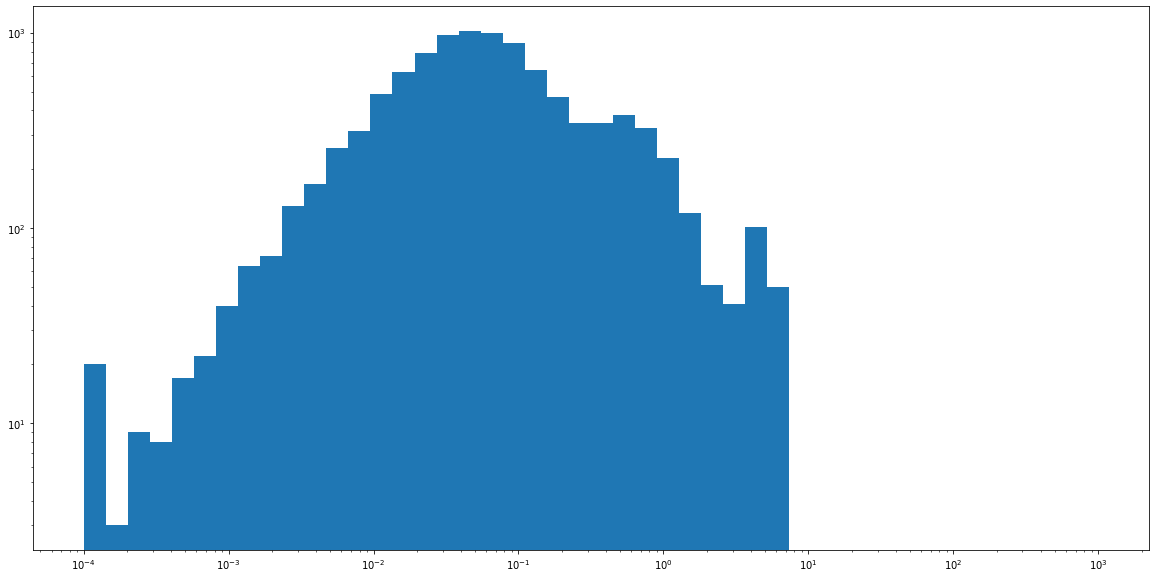

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(radii_class_change_finite, bins=bins);
ax.set_xscale('log')
ax.set_yscale('log')

In [26]:
from functools import partial

def get_radii_preds_func(radii, preds):
    return preds, radii

get_radii_inv_partial_class_change = partial(get_radii_preds_func, radii_inv_class_change)

In [31]:
rejection_rates = np.linspace(0, 1.0, 20)

# pentropy_accs = reject_by_metric(utils_attack.get_ensemble_predictive_entropy,
#                                  np_preds,
#                                  labels, 
#                                  rejection_rates,
#                                  accuracy_score)
# eentropy_accs = reject_by_metric(utils_attack.get_ensemble_expected_entropy,
#                                  np_preds,
#                                  labels, 
#                                  rejection_rates,
#                                  accuracy_score)
# bald_accs = reject_by_metric(utils_attack.get_ensemble_mi,
#                                  np_preds,
#                                  labels, 
#                                  rejection_rates,
#                                  accuracy_score)
# std_accs = reject_by_metric(utils_attack.get_ensemble_std,
#                             np_preds,
#                             labels, 
#                             rejection_rates,
#                             accuracy_score)
# minprob_accs = reject_by_metric(utils_attack.get_minprob,
#                                 np_preds[0, :],
#                                 labels, 
#                                 rejection_rates,
#                                 accuracy_score)
# random_accs = utils_attack.reject_randomly(
#     ave_preds,
#     labels, 
#     rejection_rates,
#     1000,
#     accuracy_score
# )
radii_accs_class_change = utils_attack.reject_by_metric(
    get_radii_inv_partial_class_change,
    all_preds_np,
    all_labels.detach().cpu().numpy(),
    rejection_rates,
    accuracy_score
)

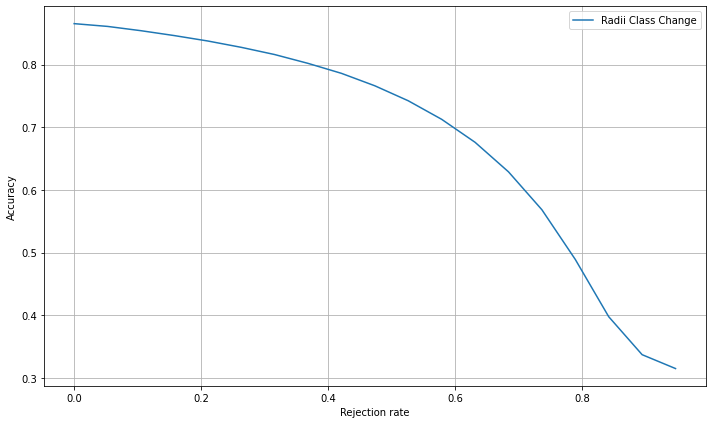

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# perf_metrics = [pentropy_accs, eentropy_accs, bald_accs, std_accs, minprob_accs, radii_accs_class_change, random_accs]
# line_labels = ['Predictive entropy', 'Expec/ted entropy', 'BALD', 'StD', 'MaxProb', 'Radii Class Change', 'Random']
perf_metrics = [radii_accs_class_change]
line_labels = ['Radii Class Change']

for metric, label in zip(perf_metrics, line_labels):
    ax.plot(rejection_rates[0:len(metric)], metric, label=label)
ax.set_xlabel('Rejection rate')
ax.set_ylabel('Accuracy')
ax.grid(visible=True)
ax.legend()

plt.tight_layout()
plt.show()